In [1]:
import sys
# import sounddevice as sd
import soundfile as sf
import numpy as np
from scipy.signal import butter, filtfilt, spectrogram, find_peaks, savgol_filter
%matplotlib widget
import matplotlib.pyplot as plt
import time

from scipy.fft import fft, fftfreq

from tqdm import tqdm, trange



In [97]:
duration = 10  # Duration of recording in seconds (slightly longer than the actual broadcast)
fs = 44000  # Sampling frequency

bps = 50 # bits per secondes
bit_duration = 1/bps  # Duration of each bit in seconds
cutoff_low = 18000
cutoff_high = 22000
f1 = 21000
f0 = 19000

In [98]:
def bandpass_filter(data, cutoff_low, cutoff_high, fs):
    # Function to design a bandpass filter
    nyquist = 0.5 * fs
    low = cutoff_low / nyquist
    high = cutoff_high / nyquist
    b, a = butter(N=8, Wn=low, btype='highpass')
    return filtfilt(b, a, data)

In [99]:
# Function to encode data as an audio signal
def encode_data(data, bit_duration, fs, f1, f0):
    signal = np.array([])
    for bit in data:
        if bit == 1:
            bit_tone = create_tone(f1, bit_duration, fs)
        else:
            bit_tone = create_tone(f0, bit_duration, fs)
        signal = np.concatenate((signal, bit_tone))
    return signal

# Function to create a sine wave for a given frequency
def create_tone(freq, duration, fs):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    tone = 0.5 * np.sin(2 * np.pi * freq * t)
    return tone

In [100]:

def fft_cross_correlation(x, y):
    N = len(x) + len(y) - 1
    X = np.fft.fft(x, N)
    Y = np.fft.fft(y, N)
    corr = np.fft.ifft(X * np.conj(Y))
    return np.abs(corr)

# def detect_signal_edge(threshold,signal, preamble_bits, fs,bit_duration, high,low,flip = False):
#     preamble = encode_data(preamble_bits,bit_duration,fs,high,low)
    
#     # Cross-correlation using FFT
#     corr = fft_cross_correlation(signal,preamble)
#     peaks, _ = find_peaks(corr, height=np.max(corr) * 0.5)
#     if flip:
#         index = np.argmax(np.flip(corr)>threshold)
#         return len(signal)-index , corr
#     index = np.argmax(corr > threshold)  # Take the first peak
#     return index ,corr

In [103]:
filename = "recordings/test_50bps_shaviv.wav"
data, fs = sf.read(filename)
elapsed_time = len(data) / fs

In [104]:
def detect_signal_edge(signal, preamble_bits, postamble_bits, fs,bit_duration, high,low,end = False):
    preamble = encode_data(preamble_bits,bit_duration,fs,high,low)
    postamble = encode_data(postamble_bits,bit_duration,fs,high,low)
    # Cross-correlation using FFT
    start_corr = fft_cross_correlation(signal,preamble)
    end_corr = fft_cross_correlation(signal,postamble)

    window_size = np.max([100,int(bit_duration*fs/4)])    
    start_smoothed_corr = savgol_filter(start_corr,window_size,3)
    end_smoothed_corr = np.flip(savgol_filter(end_corr,window_size,3))
    start_peaks, _ = find_peaks(start_smoothed_corr,width = bit_duration*fs/2)
    end_peaks, _ = find_peaks(end_smoothed_corr,width = bit_duration*fs/2)
    start_idx = 0
    if len(start_peaks) != 0:
        start_idx = start_peaks[0]
    end_idx = len(signal)
    if len(end_peaks) != 0:
        end_idx = len(signal) - end_peaks[0]
    return start_idx, end_idx, start_corr,end_corr

In [105]:
threshold = 10
filtered_data = bandpass_filter(data, cutoff_low, cutoff_high, fs)
start_preamble_bits = [1,0,1,0,1]
end_preamble_bits = [0,0,0,0]
start_idx,end_idx,start_corr,end_corr = detect_signal_edge(filtered_data, start_preamble_bits,end_preamble_bits, fs, bit_duration, f1, f0)


[125537 130940 140971 144702 148433 152068 170970 182778 190784 194677
 198429 209118 219610 223470 231178 235028 238423 246528 252295 256143
 261819 265717 278791]


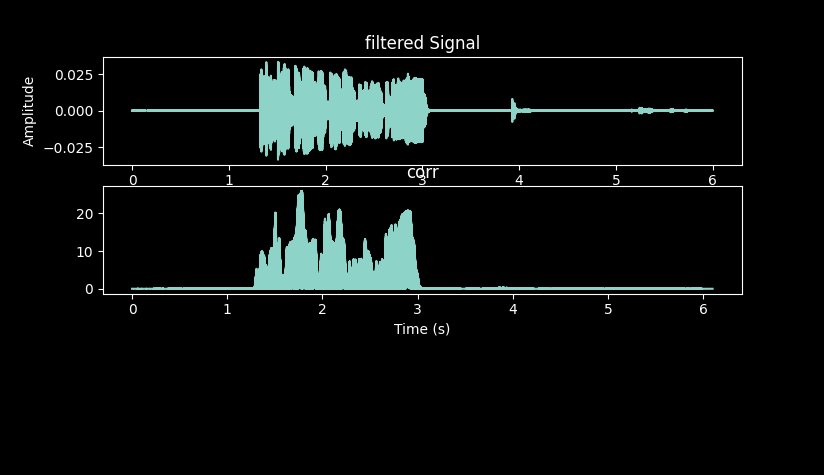

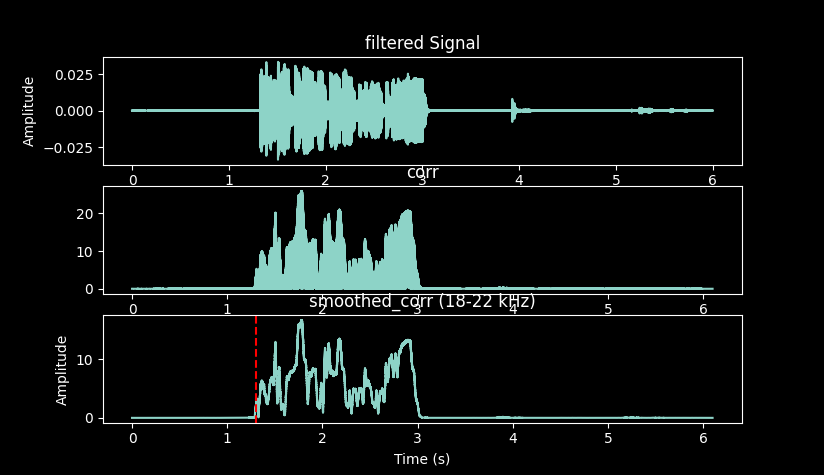

In [107]:
preamble = encode_data(start_preamble_bits,bit_duration,fs,f1,f0)

corr = fft_cross_correlation(filtered_data,preamble)


# window_size = np.max([10,int(bit_duration*fs/4)])    
window_size = 100
smoothed_corr = savgol_filter(start_corr,window_size,3)

peaks, _ = find_peaks(smoothed_corr,width = bit_duration*fs/2,height=1)
print(peaks)
start_idx = 0
if len(peaks) != 0:
    start_idx = peaks[0]
start_idx, _, _, _ = detect_signal_edge(filtered_data, start_preamble_bits,end_preamble_bits, fs, bit_duration, f1, f0)

plt.clf()

# Plot original CSS signal
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(filtered_data)) / fs, filtered_data)
plt.title('filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot filtered signal
plt.subplot(3, 1, 2)
plt.plot(np.arange(len(corr)) / fs, corr)
plt.title('corr')
plt.xlabel('Time (s)')
plt.show()

# Plot filtered signal
plt.subplot(3, 1, 3)
plt.plot(np.arange(len(smoothed_corr)) / fs, smoothed_corr)
plt.title('smoothed_corr (18-22 kHz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.axvline(x=start_idx/fs, color='r', linestyle='--', label='Average Correlation')
plt.show()



(18000.0, 22000.0)

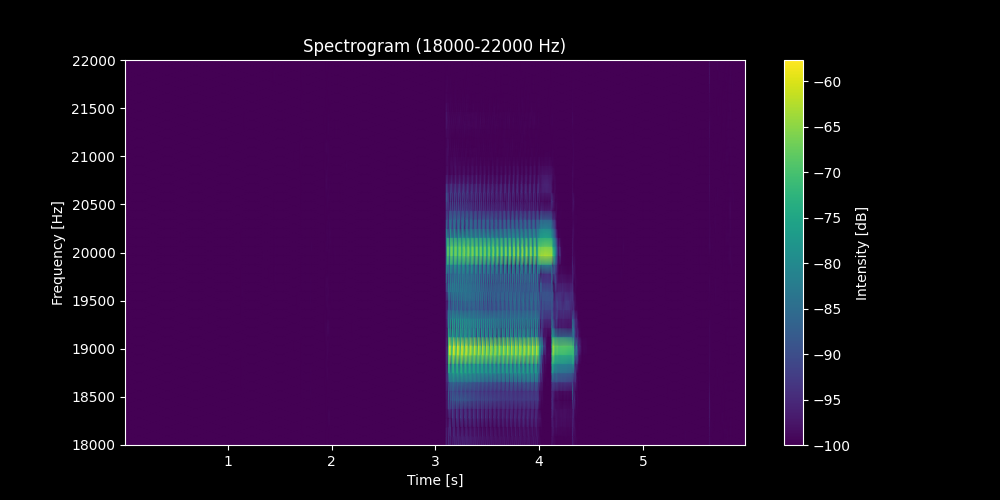

In [10]:
nperseg=1024
noverlap=64
f, t, Sxx = spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap)

# Add a small constant to avoid log of zero
Sxx += 1e-10
plt.style.use('dark_background')
# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title(f'Spectrogram ({cutoff_low}-{cutoff_high} Hz)')
plt.colorbar(label='Intensity [dB]')
plt.ylim(cutoff_low, cutoff_high)

[  2587   4978   6222  11910  14051  15131  16936  18139  20201  24012
  28572  30426  32778  35525  36834  40817  42424  43839  45182  46821
  47767  49477  52484  54530  56304  61049  62210  63857  65572  67491
  69918  71321  74815  78490  81437  83572  85398  87134  88938  90794
  92577  95981 100439 107798 109595 112158 115633 118586 120673 124821
 126599 130364 131686 134547 143094 151182 159742 162764 164155 167763
 169585 172723 174880 176285 177562 184013 184901 186713 188042 193181
 195973 196714 199046 205591 208301 213076 214813 218538]


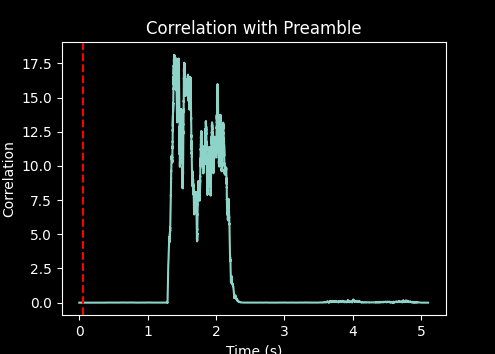

In [62]:
plt.clf()
window_size = np.max([10,int(bit_duration*fs/4)])
# arr = np.convolve(start_corr, np.ones(window_size)/window_size, mode='valid')
arr = savgol_filter(start_corr,window_size,3)
plt.plot(np.arange(len(arr))/fs, np.abs(arr))
start_peaks, _ = find_peaks(arr,width = bit_duration*fs/2)
print(start_peaks)
start_idx = start_peaks[0]


plt.axvline(x=start_idx/fs, color='r', linestyle='--', label='Average Correlation')

plt.title('Correlation with Preamble')
plt.xlabel('Time (s)')
plt.ylabel('Correlation')
plt.show()
